Beer3 Positive Results
============

1. LDA
-------

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lda_for_fragments import Ms2Lda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys

from sklearn import preprocessing
from sklearn.decomposition import PCA
import networkx as nx
from networkx.readwrite import json_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
n_topics = 100
n_samples = 100

fragment_filename = 'input/Beer_3_T10_POS_fragments.csv'
neutral_loss_filename = 'input/Beer_3_T10_POS_losses.csv'
mzdiff_filename = None

ms1_filename = 'input/Beer_3_T10_POS_ms1.csv'
ms2_filename = 'input/Beer_3_T10_POS_ms2.csv'

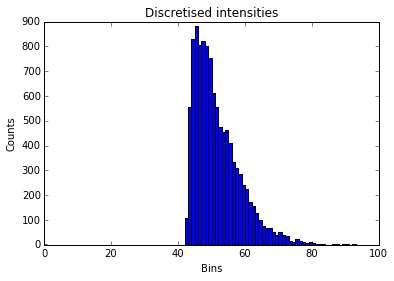

Data shape (856, 1725)
Fitting model...
DONE!


In [6]:
ms2lda = Ms2Lda(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                ms1_filename, ms2_filename, n_topics, n_samples)
ms2lda.run_lda()

In [30]:
ms2lda.write_results('beer3_pos')

Writing topics to results/beer3_pos/beer3_pos_topics.csv
Writing fragments x topics to results/beer3_pos/beer3_pos_all.csv
Writing topic docs to results/beer3_pos/beer3_pos_docs.csv


In [8]:
topic_fragments = ms2lda.model.topic_word_
n_top_frags = 20
for i,topic_dist in enumerate(topic_fragments):
    topic_f = np.array(ms2lda.data.columns.values)[np.argsort(topic_dist)][:-n_top_frags:-1]
    out_string = 'Topic {}: {}'.format(i, ', '.join(topic_f.astype('str')))
    print(out_string)

Topic 0: fragment_134.05999, loss_120.04178, fragment_143.03192, fragment_79.05417, fragment_152.07031, loss_162.05266, loss_36.02083, fragment_211.10574, fragment_275.1106, loss_64.01556, fragment_202.06802, loss_114.06812, loss_91.02682, fragment_196.09544, fragment_120.05288, loss_117.0425, fragment_172.09755, loss_173.10494, loss_80.01024
Topic 1: fragment_58.06553, fragment_118.0861, loss_159.08928, fragment_96.08073, loss_133.07373, fragment_70.06514, loss_115.0998, loss_161.10472, loss_177.09986, fragment_68.0498, loss_171.08919, fragment_114.05541, fragment_55.01824, loss_149.06875, loss_103.0638, fragment_114.09125, fragment_142.08712, loss_105.07856, fragment_274.12622
Topic 2: fragment_130.08581, fragment_56.04978, loss_17.02676, fragment_67.05455, fragment_140.07024, loss_92.04714, loss_45.0213, fragment_262.1285, fragment_144.13788, loss_171.0529, fragment_184.04364, fragment_100.02137, fragment_194.08209, fragment_115.0216, loss_115.02685, fragment_112.11181, fragment_147

10


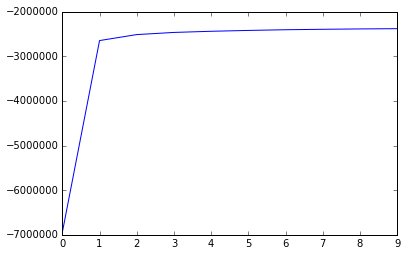

In [9]:
print len(ms2lda.model.loglikelihoods_)
plt.plot(ms2lda.model.loglikelihoods_)

2. PCA
-------

Here we use PCA to project the vector of topics for each parent peak to lower-dimensional space for visualisation purposes. First ensure the variables are scaled.

In [10]:
df = ms2lda.docdf.transpose() # topics x documents matrix
# df = fragments_topicdf.transpose() # topics x words matrix
print df.shape

# normalise and scale the variables
scaled_mat = preprocessing.scale(df, axis=0)
# print scaled_mat.mean(axis=0)
# print scaled_mat.std(axis=0)

(856, 100)


Then run PCA

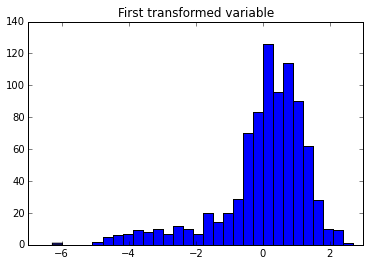

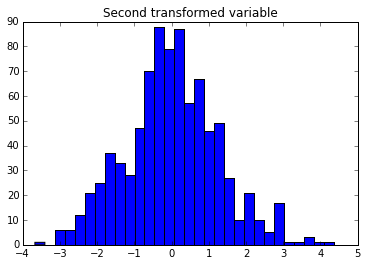

34


In [11]:
pca = PCA()
pca.fit(scaled_mat)
X_r = pca.transform(scaled_mat)

plt.figure()
plt.hist(X_r[:, 0], bins=30)
plt.title('First transformed variable')
plt.show()

plt.figure()
plt.hist(X_r[:, 1], bins=30)
plt.title('Second transformed variable')
plt.show()

print np.argmax(np.abs(pca.components_[0, :]))

But the explained variances by the first few principal components are too low ..??

In [12]:
print X_r.shape
print np.sum(pca.explained_variance_ratio_)
print('explained variance by the principal components: %s' % str(pca.explained_variance_ratio_))

(856, 100)
1.0
explained variance by the principal components: [  1.80005769e-02   1.58123214e-02   1.49090746e-02   1.48379220e-02
   1.44115622e-02   1.37721588e-02   1.35636577e-02   1.33000809e-02
   1.31717994e-02   1.29649232e-02   1.29150414e-02   1.26285855e-02
   1.24943505e-02   1.23591918e-02   1.23208586e-02   1.21355621e-02
   1.20750267e-02   1.19412532e-02   1.19353091e-02   1.18821455e-02
   1.18269844e-02   1.16733758e-02   1.16134150e-02   1.14992049e-02
   1.13834996e-02   1.12695761e-02   1.12015615e-02   1.11203740e-02
   1.10523301e-02   1.09447400e-02   1.09059922e-02   1.08194391e-02
   1.07971924e-02   1.07097405e-02   1.06744996e-02   1.06223259e-02
   1.05476117e-02   1.05035778e-02   1.04761771e-02   1.03835544e-02
   1.03655015e-02   1.03294692e-02   1.02925602e-02   1.02641658e-02
   1.01870403e-02   1.01667756e-02   1.00866585e-02   1.00696602e-02
   1.00284999e-02   9.93593158e-03   9.89852142e-03   9.86309035e-03
   9.80943785e-03   9.78590653e-03   9.7

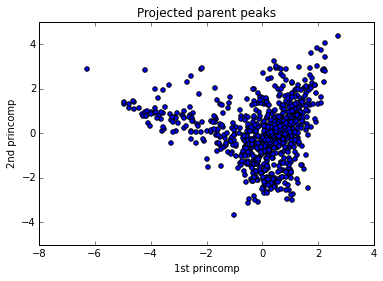

In [13]:
plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1])
plt.xlabel('1st princomp')
plt.ylabel('2nd princomp')
plt.title('Projected parent peaks')

3. Network
------------

We can try to put the parent peaks on a network too.

In [14]:
# df = topicdf.transpose() # topic x terms matrix
df = ms2lda.docdf.transpose() # documents x topic matrix
print df.shape 

(856, 100)


(856, 856)


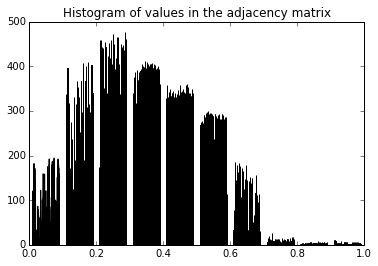

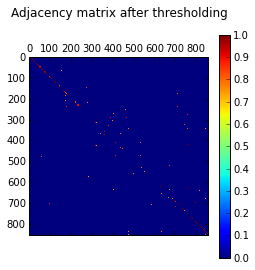

In [15]:
# create adjacency matrix A

# first compute euclidean distance between the topics
from scipy.spatial.distance import cdist
A = cdist(df, df, 'euclidean')
print A.shape

# crudely convert to similarities
maxval = A.max()
A = 1-(A/maxval)
plt.figure()
plt.hist(A)
plt.title('Histogram of values in the adjacency matrix')
plt.show()

# set a threshold for the similarity values for the network graph
for i in xrange(A.shape[0]):
    for j in xrange(A.shape[1]):
        if A[i, j] < 0.75:
            A[i, j] = 0

plt.figure()
plt.matshow(A)
plt.colorbar()
plt.title('Adjacency matrix after thresholding', y=1.2)
plt.show()

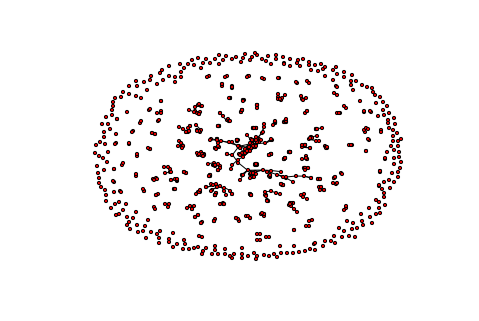

In [16]:
dt = [('len', float)]
A = A.view(dt)
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G, k=0.01, iterations=20)
nx.draw(G, pos, node_size=10, with_labels=False)

Now we see some connected components in the network graph. Below we print the largest top-20 components. 

Parent peaks in the same component are connected in the graph above, i.e. they form some sort of clusters, suggesting they share topics in common?

In [17]:
components = sorted(nx.connected_components(G), key = len, reverse=True)
counter = 1
for comp in components:
    if counter > 20:
        break
    print "Component " + str(counter)
    print "=============="
    idx = np.array(comp)-1 # nodes are indexed from 1 .. N
    ms1_rows = ms2lda.ms1.iloc[idx]
    print ms1_rows[['peakID', 'mz', 'rt', 'intensity']].to_string(index=False, justify='left')
    counter += 1
    print

Component 1
 peakID  mz           rt        intensity   
 10026    255.170156   835.064  3.377589e+05
  7762    118.086165   532.509  1.591873e+09
  7724    198.112485   554.431  1.699979e+06
  7726    204.086636   547.980  6.168024e+06
  9107    505.176703   662.160  4.163804e+06
  9113    218.124765   691.613  4.310692e+05
  9131    129.065795   632.053  1.117484e+08
 10522    372.189735   617.886  2.403418e+06
 10524    212.095090   739.434  5.293236e+06
  5734    127.050233   414.504  2.761295e+07
 10530    291.163250   564.091  3.559679e+06
  7770    138.054881   546.349  4.148492e+08
 10543    319.149792   943.404  4.451091e+05
  7785    259.128812   559.317  1.632118e+06
  9377    331.147568   714.479  2.697733e+05
  9379    408.240353   731.995  3.381979e+05
 10411    189.159682   859.763  5.534961e+07
  7038    130.049890   482.456  1.954056e+08
 11286    413.212910   970.739  3.720262e+05
  9668    471.218615   712.790  1.624741e+06
 12207    104.106957   988.951  1.219680e+0

4. Document-Topics Distribution
----------------------------------

Visualise the document-topic distributions

(856, 100)


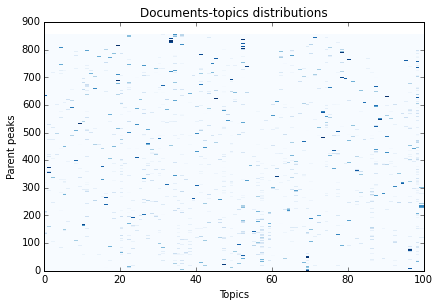

In [18]:
df = ms2lda.docdf.transpose()
print df.shape
plt.pcolor(df, norm=None, cmap='Blues')
plt.tight_layout()
plt.xlabel('Topics')
plt.ylabel('Parent peaks')
plt.title('Documents-topics distributions')
plt.show()

Nothing useful here ...